<a href="https://colab.research.google.com/github/Mayurd9/CNN-from-scratch/blob/main/cnn_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import joblib
import matplotlib.pyplot as plt

# $\textbf{Loading the data}$

In [ ]:
import tensorflow as tf
from keras.datasets import mnist

# Load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

2024-06-25 15:22:37.653274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 15:22:37.653407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 15:22:37.825652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# $\textbf{Forward Pass (FeedForward) functions}$

In [ ]:
def ff_convolution(input_matrix, weights_c, biases_c, stride, pool_size):
  n_filters=len(weights_c)
  w_filter=weights_c[0].shape[2]
  h_filter=weights_c[0].shape[1]
  output_width= int(((input_matrix.shape[2]-w_filter)/stride)+1)
  output_height= int(((input_matrix.shape[1]-h_filter)/stride)+1)
  conv_out_matrix=np.zeros((n_filters,output_height,output_width))
  flipped_weights=[np.flip(np.flip(wght , axis=1), axis=2) for wght in weights_c]
  for i in range(n_filters):
    for j in range(output_height):
      for k in range(output_width):
        conv_out_matrix[i,j,k]= np.sum(input_matrix[:, j*stride:j*stride+h_filter, k*stride:k*stride+w_filter]*flipped_weights[i]) + biases_c[i]

  conv_out_matrix=np.maximum(0,conv_out_matrix)     #ReLu
  conv_pool_matrix=np.zeros((n_filters, int(output_height/pool_size[0]), int(output_width/pool_size[1])))
  max_indices=[]
  for i in range(n_filters):
    for j in range(conv_pool_matrix.shape[1]):
      for k in range(conv_pool_matrix.shape[2]):
        region=conv_out_matrix[i][j*pool_size[0]:(j+1)*pool_size[0],k*pool_size[1]:(k+1)*pool_size[1]]
        conv_pool_matrix[i,j,k]=np.max(region)
        max_indices.append((i,)+tuple(x + y for x, y in zip(np.unravel_index(np.argmax(region), region.shape),(j*pool_size[0],k*pool_size[1]))))
  return conv_pool_matrix, conv_out_matrix, max_indices

def ff_fc_layers(X, weights, biases, test):
  L=len(weights)+1
  a=[X]
  z=[]
  for k in range(L-1):
    z.append(weights[k]@a[k] + biases[k])
    a.append(sigmoid(z[k]))
  if test==True:
    return a[-1]
  else:
    return a,z

def sigmoid(z):
  return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
 return sigmoid(z)*(1-sigmoid(z))

# $\textbf{Backpropagation functions}$

In [ ]:
def backprop_fc_layers(a,z,y,weights):
  L=len(weights)+1
  error=[(a[-1]-y)*sigmoid_prime(z[-1])]
  del_c_w_x=[error[-1]@a[-2].T]
  for l in range(2, L):
    error.insert(0, (weights[-(l-1)].T @ error[-(l-1)])*sigmoid_prime(z[-l]))
    del_c_w_x.insert(0, error[-l]@a[-l-1].T)

  del_c_b_x = error.copy()
  del_c_x= weights[0].T @ error[0]
  return del_c_b_x, del_c_w_x, del_c_x

def backprop_pool(del_c_x, max_indices, conv_pool_matrix, conv_out_matrix):
  del_c_p= np.reshape(del_c_x, conv_pool_matrix.shape)
  del_c_a= np.zeros(conv_out_matrix.shape)
  c=0
  for i in range(conv_pool_matrix.shape[0]):
    for j in range(conv_pool_matrix.shape[1]):
      for k in range(conv_pool_matrix.shape[2]):
        del_c_a[max_indices[c]]=del_c_p[i,j,k]
        c+=1
  return del_c_a

def backprop_convolution(del_c_a, conv_out_matrix,X,stride,n_filters, weights_c):
  del_a_z=np.zeros(conv_out_matrix.shape)
  for i in range(conv_out_matrix.shape[0]):
    for j in range(conv_out_matrix.shape[1]):
      for k in range(conv_out_matrix.shape[2]):
        if conv_out_matrix[i,j,k]>0:
          del_a_z[i,j,k]=1
  del_c_z= del_c_a*del_a_z

  del_c_z_flipped = np.flip(np.flip(del_c_z , axis=1), axis=2)
  out_wi= int(((X.shape[2] - del_c_z.shape[2])/stride)+1)
  out_hi= int(((X.shape[1] - del_c_z.shape[1])/stride)+1)
  h_filter= out_hi
  w_filter= out_wi
  del_c_w_con= [np.zeros((X.shape[0],out_wi,out_hi)) for _ in range(n_filters)]
  for i in range(n_filters):
    for j in range(del_c_z.shape[1]):
      for k in range(del_c_z.shape[2]):
        del_c_w_con[i] += del_c_z_flipped[i,j,k] * X[:, j*stride:j*stride+h_filter, k*stride:k*stride+w_filter]

  del_c_b_con=[np.sum(del_c_z[_]) for _ in range(n_filters)]

  flipped_weights=[np.flip(np.flip(wght , axis=1), axis=2) for wght in weights_c]
  del_c_x_con= np.zeros(X.shape)
  h_filter=flipped_weights[0].shape[1]
  w_filter=flipped_weights[0].shape[2]
  for i in range(n_filters):
    for j in range(del_c_z.shape[1]):
      for k in range(del_c_z.shape[2]):
        del_c_x_con[:, j*stride:j*stride+h_filter, k*stride:k*stride+w_filter] +=del_c_z[i,j,k]*flipped_weights[i]

  return del_c_w_con, del_c_b_con, del_c_x_con

# $\textbf{Function for Training}$

In [ ]:
def cnn_network_train(x_train,y_train,n_cnn, cnn_specs, sizes, epochs,eta,minibatch_size):

  list_cnn_weights=[[np.random.randn(cnn_specs[c][0][0],cnn_specs[c][2][1],cnn_specs[c][2][2]) for _ in range(cnn_specs[c][1])] for c in range(n_cnn) ]
  list_cnn_biases=[[np.random.randn(1,1)[0][0] for _ in range(cnn_specs[c][1])] for c in range(n_cnn)]
  biases = [np.random.randn(y, 1) for y in sizes[1:]]     #biases for fully connected layer
  weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(sizes[:-1], sizes[1:])]        #weights for fully connected layer

  for epoch in range(epochs):
    print('epoch number', epoch)
    indices=np.arange(60000)
    np.random.shuffle(indices)
    for i in range(int(60000/minibatch_size)):
      if i%1000==0:
        print('i=',i)
      minibatch_indices=indices[i*minibatch_size:(i+1)*minibatch_size]
      mini_batch_x = x_train[minibatch_indices]
      mini_batch_y = y_train[minibatch_indices]

      for j in range(len(mini_batch_x)):

        y= np.zeros((10,1))
        y[mini_batch_y[j]]=1
        conv_pool_matrix_list=[]
        conv_out_matrix_list=[]
        max_indices_list=[]
        conv_layer_input=[]
        for a in range(n_cnn):
          weights_c=list_cnn_weights[a]
          biases_c=list_cnn_biases[a]
          stride=cnn_specs[a][3]
          pool_size=cnn_specs[a][4]
          #Forward propagation
          if a==0:
            input=mini_batch_x[j].reshape(1,28,28)/255.0
          else:
            input=conv_pool_matrix_list[-1]
          conv_layer_input.append(input)
          conv_pool_matrix, conv_out_matrix, max_indices = ff_convolution(input, weights_c, biases_c, stride, pool_size)
          conv_pool_matrix_list.append(conv_pool_matrix)
          conv_out_matrix_list.append(conv_out_matrix)
          max_indices_list.append(max_indices)

        a_list ,z= ff_fc_layers(conv_pool_matrix_list[-1].reshape(-1,1), weights, biases,test=False)

        #Back propagation
        del_c_b_x, del_c_w_x, del_c_x = backprop_fc_layers(a_list,z,y,weights)
        del_c_w_con_list=[]
        del_c_b_con_list=[]
        del_c_x_in = del_c_x
        for a in range(n_cnn):
          weights_c=list_cnn_weights[-1+a]
          biases_c=list_cnn_biases[-1+a]
          stride=cnn_specs[-1+a][3]
          pool_size=cnn_specs[-1+a][4]
          n_filters=cnn_specs[-1+a][1]

          del_c_a = backprop_pool(del_c_x_in, max_indices_list[-1+a], conv_pool_matrix_list[-1+a], conv_out_matrix_list[-1+a])
          del_c_w_con, del_c_b_con, del_c_x_con = backprop_convolution(del_c_a, conv_out_matrix_list[-1+a],conv_layer_input[-1+a],stride,n_filters, weights_c)
          del_c_w_con_list.insert(0,del_c_w_con)
          del_c_b_con_list.insert(0,del_c_b_con)
          del_c_x_in = del_c_x_con.copy()

        if j==0:
          del_c_b = del_c_b_x.copy()
          del_c_w = del_c_w_x.copy()
          del_c_w_con_list_batch = del_c_w_con_list.copy()
          del_c_b_con_list_batch = del_c_b_con_list.copy()

        else:
          for m in range(len(del_c_b)):
            del_c_b[m] += del_c_b_x[m]
            del_c_w[m] += del_c_w_x[m]

          for a in range(n_cnn):
            for b in range(cnn_specs[a][1]):
              del_c_w_con_list_batch[a][b]+=del_c_w_con_list[a][b]
              del_c_b_con_list_batch[a][b]+=del_c_b_con_list[a][b]

      for n in range(len(sizes)-1):
        weights[n] = weights[n] - (eta/minibatch_size)*del_c_w[n]
        biases[n] = biases[n] - (eta/minibatch_size)*del_c_b[n]

      for a in range(n_cnn):
        for b in range(cnn_specs[a][1]):
          list_cnn_weights[a][b] = list_cnn_weights[a][b] - (eta/minibatch_size)*del_c_w_con_list_batch[a][b]
          list_cnn_biases[a][b] = list_cnn_biases[a][b] - (eta/minibatch_size)*del_c_b_con_list_batch[a][b]
      if i%1000==0:
        cnn_testing(x_train[:100],y_train[:100], cnn_specs, sizes, list_cnn_weights, list_cnn_biases, weights, biases,accuracy=True)

  return list_cnn_weights,list_cnn_biases, weights, biases

# $\textbf{Function for Testing}$

In [ ]:
#Testing
def cnn_testing(x_test,y_test, cnn_specs, sizes, list_cnn_weights, list_cnn_biases, weights, biases, accuracy):
  n_cnn=len(cnn_specs)
  if accuracy==True:
    length=len(x_test)
  else:
    length=1

  c=0
  for o in range(length):
    if accuracy==True:
      input=x_test[o].reshape(1,28,28)/255.0
    else:
      input=x_test.reshape(1,28,28)/255.0
    conv_pool_matrix_list=[]
    for a in range(n_cnn):
      weights_c=list_cnn_weights[a]
      biases_c=list_cnn_biases[a]
      stride=cnn_specs[a][3]
      pool_size=cnn_specs[a][4]
      #Forward propagation
      if a!=0:
        input=conv_pool_matrix_list[-1]
      conv_pool_matrix, conv_out_matrix, max_indices = ff_convolution(input, weights_c, biases_c, stride, pool_size)
      conv_pool_matrix_list.append(conv_pool_matrix)

    pred_label = np.argmax(ff_fc_layers(conv_pool_matrix_list[-1].reshape(-1,1), weights, biases,test=True))
    if accuracy==True:
      if pred_label == y_test[o]:
        c+=1
  if accuracy==False:
    return pred_label
  else:
    print('Accuracy=', 100*c/len(x_test))

# $\textbf{Training}$

In [ ]:
#number of convolution layers
n_cnn=1

#Provide CNN Layer specification in the format: [input matrix size(tuple), No. of filters, filter size(tuple), stride, pool filter shape(tuple)]
cnn_specs=[[(1,28,28),20,(1,5,5),1,(2,2)]]

#Provide NN specs in the format(string of:): [comma seperated number of neurons in each layer]
sizes=[2880,100,10]

list_cnn_weights,list_cnn_biases, weights, biases=cnn_network_train(x_train,y_train,n_cnn, cnn_specs, sizes, epochs=1,eta=0.5,minibatch_size=10)

epoch number 0
i= 0
Accuracy= 11.0
i= 1000
Accuracy= 94.0
i= 2000
Accuracy= 95.0
i= 3000
Accuracy= 96.0
i= 4000
Accuracy= 96.0
i= 5000
Accuracy= 96.0


In [ ]:
import joblib
joblib.dump(weights , 'weights.joblib')
joblib.dump(biases , 'biases.joblib')
joblib.dump(list_cnn_weights , 'list_cnn_weights.joblib')
joblib.dump(list_cnn_biases , 'list_cnn_biases.joblib')

['list_cnn_biases.joblib']

In [ ]:
import joblib
list_cnn_weights=joblib.load('list_cnn_weights.joblib')
list_cnn_biases=joblib.load('list_cnn_biases.joblib')
weights=joblib.load('weights.joblib')
biases=joblib.load('biases.joblib')

# $\textbf{Testing}$

In [ ]:
cnn_testing(x_test,y_test, cnn_specs, sizes, list_cnn_weights, list_cnn_biases, weights, biases,accuracy=True)

Accuracy= 97.49


# $\textbf{Testing on Random Image}$

Predicted label =  8


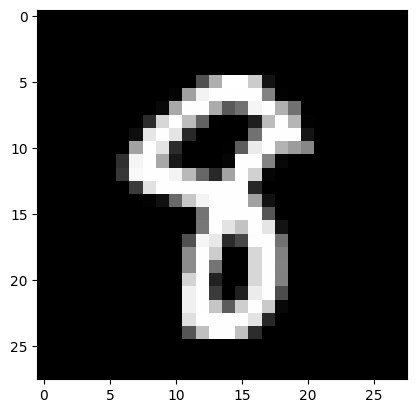

In [ ]:
n_cnn=1
cnn_specs=[[(1,28,28),20,(1,5,5),1,(2,2)]]
sizes=[2880,100,10]
random_index = np.random.randint(10000)
plt.imshow(x_test[random_index], cmap= 'gray')

pred_label = cnn_testing(x_test[random_index] , y_test[random_index], cnn_specs, sizes, list_cnn_weights, list_cnn_biases, weights, biases,accuracy=False)
print('Predicted label = ', pred_label)